In [1]:
import sys
sys.path.append("../")
import Data as dt
import Features as ft

import pandas as pd
import numpy as np
from abc import ABC, abstractmethod

#! ==================================================================================== #
#! ====================================== Base Model ================================== #
class Strategy(ABC):
    def __init__(self):
        
        self.date_name = "date"
        self.bid_open_name = "open"
        self.ask_open_name = "open"
        
        self.data = None
        self.processed_data = None
    
    #*____________________________________________________________________________________ #
    def set_names(self, date_name: str, bid_open_name: str, ask_open_name: str):
        self.date_name = date_name
        self.bid_open_name = bid_open_name
        self.ask_open_name = ask_open_name
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def set_params(self):
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def load_data(self):
        pass

    #*____________________________________________________________________________________ #
    @abstractmethod
    def process_data(self):
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def fit(self):
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def predict(self):
        pass

    #*____________________________________________________________________________________ #
    def operate(self, df: pd.DataFrame):
        # ======= I. Extract signals =======
        signals_df = self.predict(df=df)
        
        # ======= II. Objects initialization before extracting operations =======
        operations_df = pd.DataFrame(columns=['ID', 'Side', 'Entry_Date', 'Entry_Price', 'Exit_Date', 'Exit_Price', 'PnL', 'PnL_Percent'])
        
        # II.1 Set first and last signal to 0 to ensure that the operations are closed
        signals_df.reset_index(drop=True, inplace=True)

        signals_df.loc[0, "signal"] = 0
        signals_df.loc[len(signals_df) - 1, "signal"] = 0
        signals_df.loc[len(signals_df) - 2, "signal"] = 0

        # II.2 Extract the Signal Change and the Entry Points
        signals_df["Signal Change"] = signals_df["signal"].diff()
        signals_df["Signal Change"] = signals_df["Signal Change"].shift(1)

        entry_points = signals_df[signals_df["Signal Change"] != 0].copy()
        nb_entry = len(entry_points)
        
        # ======= III. Create an Operation for each entry point =======
        sequential_id = 0
        for idx in range(nb_entry - 1):
            # III.1 Extracting rows
            current_row = entry_points.iloc[idx]
            next_row = entry_points.iloc[idx + 1]
            previous_row = signals_df.iloc[current_row.name - 1]

            # III.2 Extract Information for a Long Operation
            if (current_row["Signal Change"] > 0 and previous_row["signal"] == 1):
                side = 1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.ask_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.bid_open_name]
                pnl = (exit_price - entry_price)
                pnl_percent = pnl / entry_price

            # III.3 Extract Information for a Short Operation
            elif (current_row["Signal Change"] < 0 and previous_row["signal"] == -1):
                side = -1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.bid_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.ask_open_name]
                pnl = (entry_price - exit_price)
                pnl_percent = pnl / entry_price

            else:
                continue

            # III.4 Append Operation to the DataFrame
            operations_df.loc[sequential_id] = [
                sequential_id,
                side,
                entry_date,
                entry_price,
                exit_date,
                exit_price,
                pnl,
                pnl_percent
            ]

            # --- New sequential id for the next loop iteration ---
            sequential_id += 1
        
        return operations_df, signals_df


#! ==================================================================================== #
#! ====================================== Strategies ================================== #
class MA_crossover(Strategy):
    def __init__(self):
        super().__init__()

        self.window = None
    
    #*____________________________________________________________________________________ #
    def set_params(self, window: int):
        self.window = window
    
    #*____________________________________________________________________________________ #
    def load_data(self, ticker: str, start_date: str, end_date: str):
        data = dt.load_data(ticker)
        data = data.loc[start_date:end_date]
        
        data['date'] = data.index
        data.reset_index(drop=True, inplace=True)

        self.data = data

        return data
    
    #*____________________________________________________________________________________ #
    def process_data(self):
        data = self.data.copy()
        close_series = data['close']

        moving_average = ft.average_features(price_series=close_series, window=self.window)
        data['MA'] = moving_average

        processed_data = [data]

        self.processed_data = processed_data

        return processed_data
    
    #*____________________________________________________________________________________ #
    def fit(self):
        pass

    #*____________________________________________________________________________________ #
    def predict(self, df: pd.DataFrame):
        signals_df = df.copy()
        signals_df['signal'] = 0

        signals_df.loc[signals_df['MA'] < 0, 'signal'] = 1
        signals_df.loc[signals_df['MA'] > 0, 'signal'] = -1

        return signals_df

In [2]:
import matplotlib.pyplot as plt

class Backtest():
    def __init__(self, strategy: Strategy, flat_cost: float = 0.0, slippage: float = 0.0):
        self.strategy = strategy
        self.data = None
        self.processed_data = None

        self.signals_dfs = None
        self.operations_dfs = None
        self.full_operations_df = None
        self.full_signals_df = None

        self.ticker = None
        self.start_date = None
        self.end_date = None
        self.strategy_params = None
        
        self.flat_cost = flat_cost
        self.slippage = slippage
    
    #*____________________________________________________________________________________ #
    def set_computingParams(self, date_name: str, bid_open_name: str, ask_open_name: str):
        self.strategy.set_names(date_name, bid_open_name, ask_open_name)
    
    #*____________________________________________________________________________________ #
    def set_backtestParams(self, ticker: str, start_date: str, end_date: str, strategy_params: dict):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.strategy_params = strategy_params
    
    #*____________________________________________________________________________________ #
    def run_strategy(self):
        self.strategy.set_params(**self.strategy_params)
        data = self.strategy.load_data(self.ticker, self.start_date, self.end_date)
        processed_data = self.strategy.process_data()
        
        self.data = data
        self.processed_data = processed_data
        
        operations_dfs = []
        signals_dfs = []
        for data_group in processed_data:
            operations_df, signals_df = self.strategy.operate(data_group)
            operations_dfs.append(operations_df)
            signals_dfs.append(signals_df)
        
        full_operations_df = pd.concat(operations_dfs, ignore_index=True, axis=0)
        full_signals_df = pd.concat(signals_dfs, ignore_index=True, axis=0)
        
        return full_operations_df, full_signals_df, operations_dfs, signals_dfs
    
    #*____________________________________________________________________________________ #
    def apply_costs(self, operations_df: pd.DataFrame):
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply slippage on Entry/Exit prices =======
        # II.1 Adjust entry prices
        adjusted_operations_df["Entry_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Entry_Price"] * (1 + self.slippage) if row["Side"] == 1 else row["Entry_Price"] * (1 - self.slippage), axis=1
        )

        # II.2 Adjust exit prices
        adjusted_operations_df["Exit_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Exit_Price"] * (1 - self.slippage) if row["Side"] == 1 else row["Exit_Price"] * (1 + self.slippage), axis=1
        )

        # ======= III. Adjust the PnL =======
        adjusted_operations_df["PnL_Adjusted"] = (
            adjusted_operations_df["Exit_Price_Adjusted"] - adjusted_operations_df["Entry_Price_Adjusted"]
        ) * adjusted_operations_df["Side"]

        # ======= IV. Apply flat cost =======
        adjusted_operations_df["PnL_Adjusted"] -= self.flat_cost
        adjusted_operations_df["PnL_Percent_Adjusted"] = adjusted_operations_df["PnL_Adjusted"] / adjusted_operations_df["Entry_Price_Adjusted"]

        return adjusted_operations_df

    #*____________________________________________________________________________________ #
    def run_backtest(self):
        full_operations_df, full_signals_df, operations_dfs, signals_dfs = self.run_strategy()
        full_operations_df = self.apply_costs(full_operations_df)
        
        cumulative_returns = (1 + full_operations_df["PnL_Percent"]).cumprod()
        cumulative_returns_adjusted = (1 + full_operations_df["PnL_Percent_Adjusted"]).cumprod()
        
        full_operations_df['Cumulative_PnL'] = cumulative_returns
        full_operations_df['Cumulative_PnL_Adjusted'] = cumulative_returns_adjusted
        
        self.full_operations_df = full_operations_df
        self.full_signals_df = full_signals_df
        self.operations_dfs = operations_dfs
        self.signals_dfs = signals_dfs
        
        return full_operations_df, full_signals_df, operations_dfs, signals_dfs
    
    #*____________________________________________________________________________________ #
    def plot_returns(self):
        
        plt.figure(figsize=(17, 5))
        plt.plot(self.full_operations_df['Cumulative_PnL'], label='Cumulative PnL')
        plt.plot(self.full_operations_df['Cumulative_PnL_Adjusted'], label='Cumulative PnL Adjusted')
        plt.legend()
        plt.show()
        
        

In [3]:
crossover = MA_crossover()
crossover.set_params(window=5)
print(f'Parameters set to : {crossover.window}')

data = crossover.load_data(ticker="AAPL", start_date="2021-01-01", end_date="2021-12-31")
print(f'Data loaded with shape : {data.shape} and columns : {data.columns.to_list()}')

processed_data = crossover.process_data()
print(f'Data processed with shape : {processed_data[0].shape} and columns : {processed_data[0].columns.to_list()}')

signals_df = crossover.predict(df=processed_data[0])
print(f'Signals extracted with shape : {signals_df.shape} and columns : {signals_df.columns.to_list()}')

crossover.set_names(date_name="date", bid_open_name="close", ask_open_name="close")
operations_df, signals_df = crossover.operate(df=signals_df)
print(f'Operations extracted with shape : {operations_df.shape} and columns : {operations_df.columns.to_list()}')

Parameters set to : 5
Data loaded with shape : (252, 9) and columns : ['code', 'exchange', 'open', 'high', 'low', 'close', 'volume', 'count_trx', 'date']
Data processed with shape : (252, 10) and columns : ['code', 'exchange', 'open', 'high', 'low', 'close', 'volume', 'count_trx', 'date', 'MA']
Signals extracted with shape : (252, 11) and columns : ['code', 'exchange', 'open', 'high', 'low', 'close', 'volume', 'count_trx', 'date', 'MA', 'signal']
Operations extracted with shape : (58, 8) and columns : ['ID', 'Side', 'Entry_Date', 'Entry_Price', 'Exit_Date', 'Exit_Price', 'PnL', 'PnL_Percent']


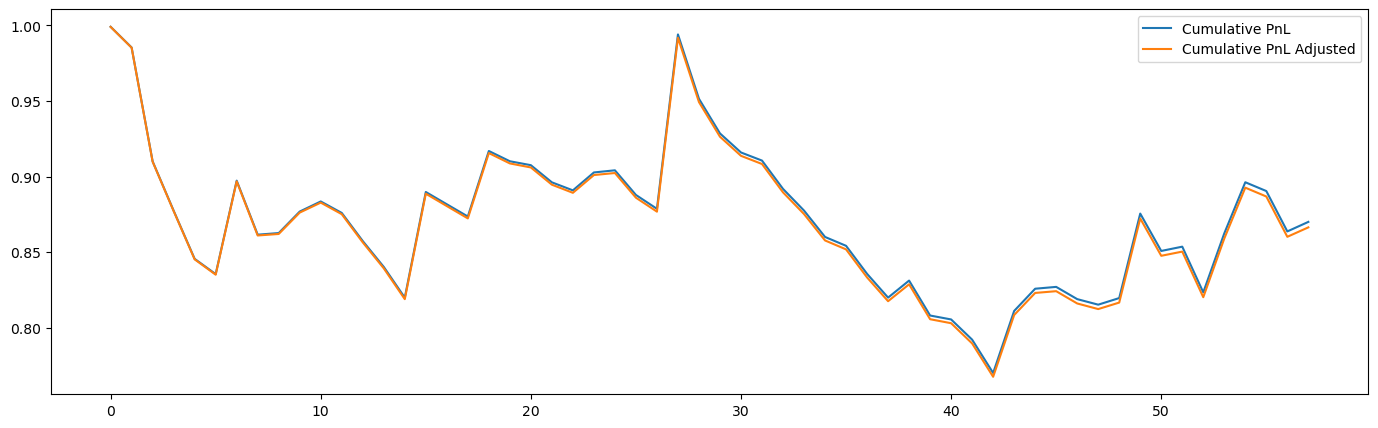

In [8]:
strategy = MA_crossover()
strategy_params = {"window": 5}

backtest = Backtest(strategy=strategy, flat_cost=0.01, slippage=0.0)
backtest.set_computingParams(date_name="date", bid_open_name="close", ask_open_name="close")
backtest.set_backtestParams(ticker="AAPL", start_date="2021-01-01", end_date="2021-12-31", strategy_params=strategy_params)
full_operations_df, full_signals_df, operations_dfs, signals_dfs = backtest.run_strategy()
full_operations_df = backtest.apply_costs(full_operations_df)

full_operations_df = backtest.run_backtest()
backtest.plot_returns()